In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        for song in os.listdir(genre_folder):
            if song.endswith('.au'):
                signal, sr = librosa.load(os.path.join(genre_folder, song))
                melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                song_specs.append(melspec)
                genres.append(genre_to_idx[genre])
    return song_specs, genres, genre_to_idx, idx_to_genre

song_specs, genres, genre_to_idx, idx_to_genre = load_songs('/home/douwe/genres')
song_specs[0].shape

(1280, 128)

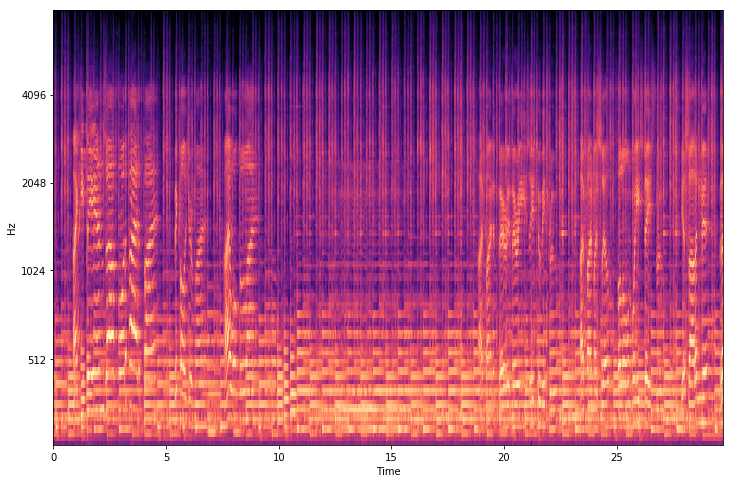

In [3]:
librosa.display.specshow(librosa.power_to_db(song_specs[101].T,
                                              ref=np.max),
                          y_axis='mel', fmax=8000,
                          x_axis='time')

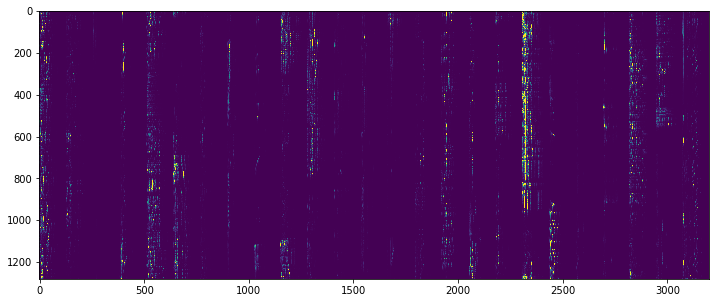

In [4]:
def show_spectogram(show_genre):
    show_genre = genre_to_idx[show_genre]
    specs = []
    for spec, genre in zip(song_specs, genres):
        if show_genre == genre:
            specs.append(spec)
            if len(specs) == 25:
                break
    if not specs:
        return 'not found!'
    x = np.concatenate(specs, axis=1)
    x = (x - x.min()) / (x.max() - x.min())
    plt.imshow((x *20).clip(0, 1.0))

show_spectogram('classical')

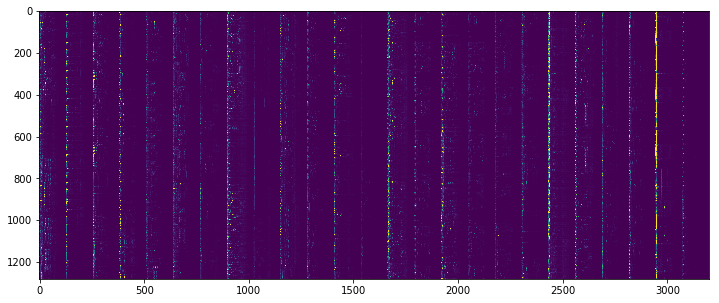

In [5]:
show_spectogram('metal')

In [15]:
def lstm_model(input_shape):
    inputs = Input(shape=input_shape, name='input')
    lstm_1 = LSTM(units=128, return_sequences=False)(inputs)
    
    dense2 = Dense(10, activation='softmax')(lstm_1)

    model = Model(inputs=[inputs], outputs=[dense2])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs
    levels = 64
    
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2
    
    # Global Layers
    x = GlobalMaxPooling1D()(x)

    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    labels = Dense(10, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[labels])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = cnn_model((128, 128))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 63, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 128)           512       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 30, 128)           0         
__________

In [16]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)


genres_one_hot = keras.utils.to_categorical(genres, num_classes=len(genre_to_idx))

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot), 
    test_size=0.1, stratify=genres)

x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

x_train.shape, y_train.shape

((9000, 128, 128), (9000, 10))

In [17]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
      min_delta=0,
      patience=3,
      verbose=0,
      mode='auto')

    # Fit the model
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 1s - loss: 2.5397 - acc: 0.2086 - val_loss: 2.2294 - val_acc: 0.1600
Epoch 2/100
9000/9000 [==============================] - 0s - loss: 2.0240 - acc: 0.3117 - val_loss: 2.2250 - val_acc: 0.1700
Epoch 3/100
9000/9000 [==============================] - 0s - loss: 1.8489 - acc: 0.3609 - val_loss: 2.1989 - val_acc: 0.2010
Epoch 4/100
9000/9000 [==============================] - 0s - loss: 1.7353 - acc: 0.3958 - val_loss: 2.1334 - val_acc: 0.2300
Epoch 5/100
9000/9000 [==============================] - 0s - loss: 1.6214 - acc: 0.4401 - val_loss: 2.0443 - val_acc: 0.3700
Epoch 6/100
9000/9000 [==============================] - 0s - loss: 1.5458 - acc: 0.4697 - val_loss: 1.8712 - val_acc: 0.4230
Epoch 7/100
9000/9000 [==============================] - 0s - loss: 1.4756 - acc: 0.4910 - val_loss: 1.6644 - val_acc: 0.4970
Epoch 8/100
9000/9000 [==============================] - 0s - loss: 1.

In [19]:
model.save('zoo/15/song_classify.h5')

In [18]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.72999999999999998

In [20]:
cm = confusion_matrix(np.argmax(pred_values, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[65  5  2  4  0  4  1 10  0  2]
 [14 59 13  0  0  0 10 17  4  1]
 [ 6  5 76  0  0  6  7 18  0  0]
 [ 2  3  0 80 34  2  4  1  9 16]
 [ 2  3  0  0 66  0  0  0  2  0]
 [ 0 11  2  1  0 77 12  0  9  5]
 [ 3 12  5  4  0 11 64 12  0  9]
 [ 1  0  2  0  0  0  1 41  0  0]
 [ 6  1  0  9  0  0  0  0 63 42]
 [ 1  1  0  2  0  0  1  1 13 25]]


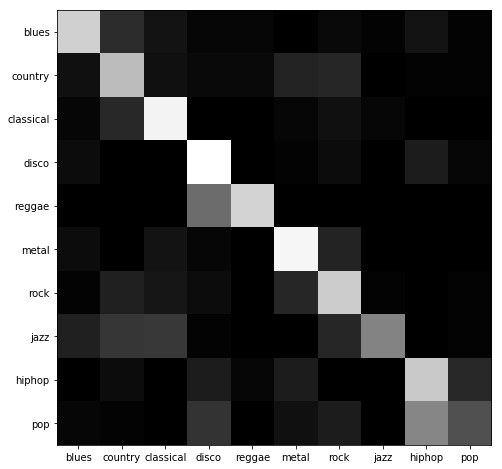

In [21]:
plt.imshow(cm.T, interpolation='nearest', cmap='gray')
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre)
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()

In [14]:
m1 = cnn_melspect_1D_org((128, 128))
m2 = cnn_melspect_1D((128, 128))
ac1 = 0.61 * 5
ac2 = 0
for i in range(5):
    history = m1.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac1 += history.history['val_acc'][-1]
    history = m2.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac2 += history.history['val_acc'][-1]

print(ac1 / 5, ac2 / 5)

1.24420000563 0.538800003624
